Import the Q# module.

This enables the `%%qsharp` magic and initializes a Q# interpreter singleton.

In [1]:
import qsharp


Run Q# using the `%%qsharp` magic.

`DumpMachine()` and `Message()` output get formatted as HTML. Return value is shown as cell output.

In [2]:
%%qsharp

operation Main() : Result {
    use q = Qubit();
    X(q);
    Microsoft.Quantum.Diagnostics.DumpMachine();
    let r = M(q);
    Message($"The result of the measurement is {r}");
    Reset(q);
    r
}

Main()


STATE:
|1⟩: 1.0000+0.0000𝑖

The result of the measurement is One

One

`qsharp.eval()` does the same thing as the `%%qsharp` magic.

`DumpMachine()` and `Message()` print to stdout and get displayed in the notebook as plain text

In [3]:
qsharp.eval("Main()")


STATE:
|1⟩: 1.0000+0.0000𝑖
The result of the measurement is One


One

Assign a result to a Python variable.

In [4]:
result = qsharp.eval("1 + 2")

print(f"Result: {result} (type: {type(result).__name__})")


Result: 3 (type: int)


Errors are exceptions. 

Catch and handle compilation errors.

In [5]:
from qsharp import QSharpError

try:
    qsharp.eval(
        """
operation Foo() : Unit {
    Bar();
    Baz();
}
"""
    )
except QSharpError as ex:
    print(ex)


Qsc.Resolve.NotFound

  × name error
  ╰─▶ `Bar` not found
   ╭─[line_3:2:1]
 2 │ operation Foo() : Unit {
 3 │     Bar();
   ·     ───
 4 │     Baz();
   ╰────
Qsc.Resolve.NotFound

  × name error
  ╰─▶ `Baz` not found
   ╭─[line_3:3:1]
 3 │     Bar();
 4 │     Baz();
   ·     ───
 5 │ }
   ╰────
Qsc.TypeCk.AmbiguousTy

  × type error
  ╰─▶ insufficient type information to infer type
   ╭─[line_3:2:1]
 2 │ operation Foo() : Unit {
 3 │     Bar();
   ·     ─────
 4 │     Baz();
   ╰────
  help: provide a type annotation
Qsc.TypeCk.AmbiguousTy

  × type error
  ╰─▶ insufficient type information to infer type
   ╭─[line_3:3:1]
 3 │     Bar();
 4 │     Baz();
   ·     ─────
 5 │ }
   ╰────
  help: provide a type annotation



Catch and handle runtime errors.

In [6]:
try:
    qsharp.eval("operation Foo() : Unit { use q = Qubit(); X(q) } Foo()")
except QSharpError as ex:
    print(ex)


Error: Qubit0 released while not in |0⟩ state
Call stack:
    at QIR.Runtime.__quantum__rt__qubit_release in core/qir.qs
    at Foo in line_4
Qsc.Eval.ReleasedQubitNotZero

  × runtime error
  ╰─▶ Qubit0 released while not in |0⟩ state
   ╭─[line_4:1:1]
 1 │ operation Foo() : Unit { use q = Qubit(); X(q) } Foo()
   ·                          ────────┬───────
   ·                                  ╰── Qubit0
   ╰────
  help: qubits should be returned to the |0⟩ state before being released to
        satisfy the assumption that allocated qubits start in the |0⟩ state



A runtime error that's not caught gets reported as a Python exception.

In [7]:
qsharp.eval("operation Foo() : Unit { use q = Qubit(); X(q) } Foo()")


QSharpError: Error: Qubit1 released while not in |0⟩ state
Call stack:
    at QIR.Runtime.__quantum__rt__qubit_release in core/qir.qs
    at Foo in line_5
[31mQsc.Eval.ReleasedQubitNotZero[0m

  [31m×[0m runtime error
[31m  ╰─▶ [0mQubit1 released while not in |0⟩ state
   ╭─[[36;1;4mline_5[0m:1:1]
 [2m1[0m │ operation Foo() : Unit { use q = Qubit(); X(q) } Foo()
   · [35;1m                         ────────┬───────[0m
   ·                                  [35;1m╰── [35;1mQubit1[0m[0m
   ╰────
[36m  help: [0mqubits should be returned to the |0⟩ state before being released to
        satisfy the assumption that allocated qubits start in the |0⟩ state


In `%%qsharp` cells, exceptions are handled and displayed as error text.

In [8]:
%%qsharp

operation Bar() : Unit {
    use q = Qubit();
    Microsoft.Quantum.Diagnostics.DumpMachine();
    X(q);
}

Bar()


STATE:
|011⟩: 1.0000+0.0000𝑖

Error: Qubit2 released while not in |0⟩ state
Call stack:
    at QIR.Runtime.__quantum__rt__qubit_release in core/qir.qs
    at Bar in line_6
Qsc.Eval.ReleasedQubitNotZero

  × runtime error
  ╰─▶ Qubit2 released while not in |0⟩ state
   ╭─[line_6:2:1]
 2 │ operation Bar() : Unit {
 3 │     use q = Qubit();
   ·     ────────┬───────
   ·             ╰── Qubit2
 4 │     Microsoft.Quantum.Diagnostics.DumpMachine();
   ╰────
  help: qubits should be returned to the |0⟩ state before being released to
        satisfy the assumption that allocated qubits start in the |0⟩ state


InvisibleError: 

Streaming output for long running operations.

In [9]:
%%qsharp

open Microsoft.Quantum.Diagnostics;

operation Main() : Unit {
    Message("Generating random bit... ");
    for i in 0..400000 {
        use q = Qubit();
        H(q);
        let r = M(q);
        if (i % 100000) == 0 {
            DumpMachine();
            Message($"Result: {r}");
        }
        Reset(q);
    }
}

Main()


Generating random bit...

STATE:
|1111⟩: 1.0000+0.0000𝑖

Result: One

STATE:
|0111⟩: 1.0000+0.0000𝑖

Result: Zero

STATE:
|0111⟩: 1.0000+0.0000𝑖

Result: Zero

STATE:
|0111⟩: 1.0000+0.0000𝑖

Result: Zero

STATE:
|0111⟩: 1.0000+0.0000𝑖

Result: Zero

Running multiple shots for an expression. Each shot uses an independent instance of the simulator. A list of results (or runtime errors) is returned.

In [10]:
%%qsharp

operation RandomBit() : Result {
    use q = Qubit();
    H(q);
    let res = M(q);
    Reset(q);
    return res;
}


In [11]:
results = qsharp.run("RandomBit()", 10)

results


[Zero, Zero, Zero, One, Zero, Zero, Zero, Zero, One, One]

The results can then be processed, e.g. plotted in a histogram using popular Python libraries.

In [ ]:
%pip install matplotlib


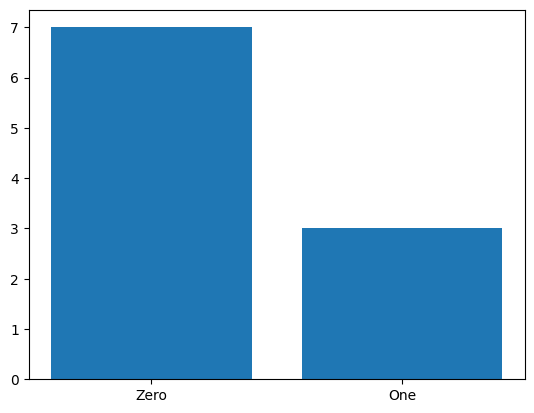

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Sort the results so that the histogram labels appear in the correct order
results.sort()
# Count the number of times each result appears
counts = Counter(results)

(values, counts) = counts.keys(), counts.values()
xlabels = np.arange(len(counts))
plt.bar(xlabels, counts)
plt.xticks(xlabels, values)
plt.show()


In [ ]:
%pip install pandas


/tmp/ipykernel_18401/2211578213.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas


<Axes: >

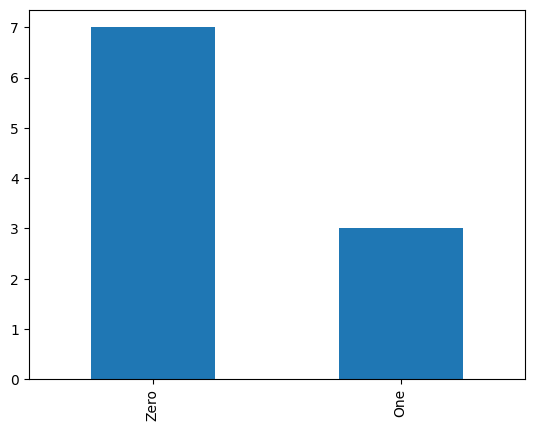

In [13]:
import pandas
from collections import Counter

# Sort the results so that the histogram labels appear in the correct order
results.sort()
pandas.Series(results).value_counts(sort=False).plot(kind='bar')


A compiler error in the entry expression:

In [14]:
qsharp.run("""RandomBit("a")""", 10)


QSharpError: [31mQsc.TypeCk.TyMismatch[0m

  [31m×[0m type error
[31m  ╰─▶ [0mexpected Unit, found String
   ╭─[[36;1;4m<entry>[0m:1:1]
 [2m1[0m │ RandomBit("a")
   · [35;1m──────────────[0m
   ╰────


Some shots throw runtime errors:

In [15]:
%%qsharp

operation Bad() : Unit {
    use q = Qubit();
    H(q);
    let res = M(q);
    if (res == One) {
        // Do something bad, sometimes
        use q2 = Qubit();
        X(q2);
    }
}


In [16]:
qsharp.run("Bad()", 10)


QSharpError: Error: Qubit1 released while not in |0⟩ state
Call stack:
    at QIR.Runtime.__quantum__rt__qubit_release in core/qir.qs
    at Bad in line_9
[31mQsc.Eval.ReleasedQubitNotZero[0m

  [31m×[0m runtime error
[31m  ╰─▶ [0mQubit1 released while not in |0⟩ state
   ╭─[[36;1;4mline_9[0m:7:1]
 [2m7[0m │         // Do something bad, sometimes
 [2m8[0m │         use q2 = Qubit();
   · [35;1m        ────────┬────────[0m
   ·                 [35;1m╰── [35;1mQubit1[0m[0m
 [2m9[0m │         X(q2);
   ╰────
[36m  help: [0mqubits should be returned to the |0⟩ state before being released to
        satisfy the assumption that allocated qubits start in the |0⟩ state
